<a href="https://colab.research.google.com/github/kinjalbhoiwala/mtech/blob/main/semester_3/Year2Sem1_ADL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group members
<table width="100%">
  <tr>
    <th width="25%">Name</th>
    <th width="40%">Email</th>
    <th width="20%">Student ID</th>
    <th width="15%">Contribution</th>
  </tr>
  <tr>
    <td>G. Ankur Vatsa</td>
    <td>2023aa05727@wilp.bits-pilani.ac.in</td>
    <td>2023aa05727</td>
    <td>100%</td>
  </tr>
  <tr>
    <td>Meet Soni</td>
    <td>2023aa05655@wilp.bits-pilani.ac.in</td>
    <td>2023aa05655</td>
    <td>100%</td>
  </tr>
  <tr>
    <td>Kinjal Bhoiwala</td>
    <td>2023aa05490@wilp.bits-pilani.ac.in</td>
    <td>2023aa05490</td>
    <td>100%</td>
  </tr>
  <tr>
    <td>Randhawane Santosh Baban</td>
    <td>2023aa05828@wilp.bits-pilani.ac.in</td>
    <td>2023aa05828</td>
    <td>100%</td>
  </tr>
</table>

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D
from sklearn.metrics.pairwise import cosine_similarity


# Task 0
Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images! Use randomly selected 70% of the dataset as training set and remaining 30% as the test set.

In [15]:
# Load the CIFAR10 dataset from Keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to grayscale
x_train = tf.image.rgb_to_grayscale(x_train)
x_test = tf.image.rgb_to_grayscale(x_test)

# Flatten the images
x_train = tf.reshape(x_train, (x_train.shape[0], -1))
x_test = tf.reshape(x_test, (x_test.shape[0], -1))

# Normalize the data
x_train = tf.cast(x_train, tf.float32) / 255.0  # Cast x_train to float32 before division
x_test = tf.cast(x_test, tf.float32) / 255.0    # Cast x_test to float32 before division

# Convert TensorFlow tensors to NumPy arrays before splitting
x_train = x_train.numpy()
x_test = x_test.numpy()

# Split the training data into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)


# Task 1
Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.



In [20]:
# Standard PCA
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

# Randomized PCA
rpca = PCA(n_components=200, svd_solver='randomized')
x_train_rpca = rpca.fit_transform(x_train)
x_val_rpca = rpca.transform(x_val)
x_test_rpca = rpca.transform(x_test)

#Eigenvectors of Standard PCA
eigenvectors = pca.components_

print("Shape of original data:", x_train.shape)
print("Shape of PCA transformed data:", x_train_pca.shape)
print("Shape of eigenvectors (principal components):", eigenvectors.shape)

# Explained variance ratio
#print("Explained variance ratio:", pca.explained_variance_ratio_)

# Number of components kept
print("Number of components:", pca.n_components_)


Shape of original data: (35000, 1024)
Shape of PCA transformed data: (35000, 160)
Shape of eigenvectors (principal components): (160, 1024)
Number of components: 160
Number of components with RandomPCA: 200


In [21]:
# Train logistic regression models
lr_pca = LogisticRegression(multi_class='ovr')
lr_pca.fit(x_train_pca, y_train.ravel())

lr_rpca = LogisticRegression(multi_class='ovr')
lr_rpca.fit(x_train_rpca, y_train.ravel())

# Predict probabilities on the test set
y_prob_pca = lr_pca.predict_proba(x_test_pca)
y_prob_rpca = lr_rpca.predict_proba(x_test_rpca)

# Calculate ROC curves for multiclass using 'ovr' (one-vs-rest) approach
fpr_pca = dict()
tpr_pca = dict()
roc_auc_pca = dict()
for i in range(10): # CIFAR10 has 10 classes
    fpr_pca[i], tpr_pca[i], _ = roc_curve(y_test.ravel() == i, y_prob_pca[:, i])
    roc_auc_pca[i] = auc(fpr_pca[i], tpr_pca[i])

fpr_rpca = dict()
tpr_rpca = dict()
roc_auc_rpca = dict()
for i in range(10):
    fpr_rpca[i], tpr_rpca[i], _ = roc_curve(y_test.ravel() == i, y_prob_rpca[:, i])
    roc_auc_rpca[i] = auc(fpr_rpca[i], tpr_rpca[i])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


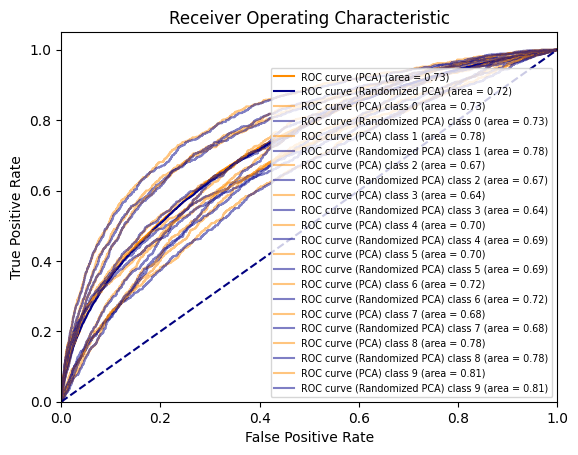

In [22]:
# Plot micro-averaged ROC curve for PCA
fpr_pca["micro"], tpr_pca["micro"], _ = roc_curve(tf.keras.utils.to_categorical(y_test.ravel()).ravel(), y_prob_pca.ravel())
roc_auc_pca["micro"] = auc(fpr_pca["micro"], tpr_pca["micro"])
plt.plot(fpr_pca["micro"], tpr_pca["micro"], color='darkorange', label='ROC curve (PCA) (area = %0.2f)' % roc_auc_pca["micro"])

# Plot micro-averaged ROC curve for Randomized PCA
fpr_rpca["micro"], tpr_rpca["micro"], _ = roc_curve(tf.keras.utils.to_categorical(y_test.ravel()).ravel(), y_prob_rpca.ravel())
roc_auc_rpca["micro"] = auc(fpr_rpca["micro"], tpr_rpca["micro"])
plt.plot(fpr_rpca["micro"], tpr_rpca["micro"], color='darkblue', label='ROC curve (Randomized PCA) (area = %0.2f)' % roc_auc_rpca["micro"])

# Plot ROC curves for each class individually
for i in range(10):
    plt.plot(fpr_pca[i], tpr_pca[i], color='darkorange', alpha=0.5,  # Use alpha for transparency
             label='ROC curve (PCA) class %d (area = %0.2f)' % (i, roc_auc_pca[i]))
    plt.plot(fpr_rpca[i], tpr_rpca[i], color='darkblue', alpha=0.5,
             label='ROC curve (Randomized PCA) class %d (area = %0.2f)' % (i, roc_auc_rpca[i]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# Adjust legend placement and font size
plt.legend(loc='lower right', fontsize='x-small')
plt.show()

# Task 2
Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

In [23]:
# Define the input layer
input_dim = x_train.shape[1]  # Number of features

# Define the latent dimension (choose appropriately)
latent_dim = 100

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(latent_dim, activation='linear')(input_layer)

# Define the decoder
decoded = Dense(input_dim, activation='linear')(encoded)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test))


Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0361 - val_loss: 0.0087
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 9/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050 - val_loss: 0.0050


**Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.**

---
Explaination based on following output of the similarity matrix.

Since the diagonal elements of this matrix is far from being close to 1 which indicates low similarity. than means, Autoencoder has learned a different subspace than to PCA.




In [30]:
# Extract the encoder weights
encoder_weights = autoencoder.layers[1].get_weights()[0]

# Calculate the eigenvectors of the covariance matrix of the encoder weights
eigenvalues, eigenvectors = np.linalg.eig(np.cov(encoder_weights.T))

encoder_weights_transposed = encoder_weights.T

similarity_matrix = cosine_similarity(pca.components_, encoder_weights_transposed)
print("Cosine similarity matrix:\n", similarity_matrix)

#Ideally, the diagonal values should be close to 1, and off-diagonal values close to 0
average_similarity=np.mean(np.diag(similarity_matrix))
print(f"Average cosine similarity of diagonal {average_similarity}")

#Since the diagonal elements of this matrix is far from being close to 1 which indicates low similarity. than means, Autoencoder has learned a different subspace than to PCA.


Cosine similarity matrix:
 [[-0.01735707 -0.01056011  0.00188211 ...  0.02510286  0.00624157
   0.00020473]
 [ 0.04680183  0.0337373   0.00599099 ... -0.09421629 -0.0029166
  -0.00608062]
 [ 0.00445379 -0.01102843 -0.0107913  ... -0.03416891 -0.00894844
  -0.00139418]
 ...
 [-0.00226526 -0.00223453 -0.00057672 ...  0.00254206  0.00209783
   0.00039826]
 [-0.00191802  0.00048936 -0.00050049 ...  0.00537045 -0.00381843
  -0.00134462]
 [ 0.00159582  0.00039297  0.00013299 ... -0.00074594 -0.00262122
   0.00018264]]
Average cosine similarity of diagonal -0.0016459800535812974


# Task 3
a) Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset.

In [7]:
# Define the encoder
input_img = Input(shape=(32, 32, 1))  # Adjust the shape
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# Define the decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Reshape the data to match the expected input shape of the autoencoder
x_train = x_train.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6060 - val_loss: 0.5820
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5804 - val_loss: 0.5790
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5783 - val_loss: 0.5776
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5775 - val_loss: 0.5765
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5763 - val_loss: 0.5760
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5760 - val_loss: 0.5753
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5754 - val_loss: 0.5748
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5748 - val_loss: 0.5746
Epoch 9/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5749 - val_loss: 0.5743
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5733 - val_loss: 0.5766


b) What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

## Key Factors Affecting Reconstruction Error:

1.   Hidden Node Distribution:
If the number of nodes is reduced across layers (e.g.,𝑁 → 𝑁 / 2 → 𝑁 / 3), the middle layer will act as a bottleneck. This bottleneck restricts the information passed through the network and forces the model to learn a compact, meaningful representation.

2.   Activation Functions:

a\) Sigmoid in Encoder Layers:

Outputs values in the range \[0, 1\], which can cause vanishing gradients during backpropagation, especially with deeper networks.
It may also limit the representational capacity if the data range is significantly different.

Linear in Final Decoder Layer:
Ensures that the output is not constrained and can represent a wider range of values, suitable for reconstructing normalized data.

Number of Nodes:

An approximate equal distribution of hidden nodes may result in a less effective representation compared to a carefully designed architecture (e.g., progressively reducing and then increasing nodes).
If the total number of hidden nodes is small, the model may underfit, increasing reconstruction error.
Training Dynamics:

Sigmoid activations require careful initialization and normalization of inputs to avoid saturation. Otherwise, learning may slow down, leading to higher error.
Data Complexity:

Highly complex data (like CIFAR-10 images) may require more nodes or layers to capture intricate patterns.

## Estimation of Reconstruction Error:
Case of Insufficient Representation:
If the hidden layers fail to capture the data's structure due to insufficient capacity or bottleneck, the reconstruction error will be high.
Case of Sufficient Representation:
With a well-optimized architecture and training process, the reconstruction error will primarily depend on the noise and variability in the dataset. For normalized CIFAR-10 data, an MSE in the range of 0.02 to 0.05 is typical for a reasonably configured autoencoder.

## Suggestions to Minimize Reconstruction Error:
Layer Size Optimization:

Instead of exact equal distribution, try progressively reducing and increasing sizes (e.g., 1024 → 512 → 256 → 512 → 1024).

Activation Tuning:

Replace sigmoid with ReLU or LeakyReLU in the encoder for better gradient flow.
Use sigmoid or linear activations based on the data range in the final decoder layer.

Normalization:

Normalize inputs to a range \[0, 1\] for better compatibility with sigmoid activations.

Regularization:
Add dropout or L2 regularization to prevent overfitting and improve generalization.

Experimentation:
Train and evaluate the autoencoder with multiple configurations to determine the best trade-off between model complexity and reconstruction error.

# Task 4
Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

   1

1    1

   1    

1     1

   1

7 will be "classified" as

   1

0    1

   0    

0    1

   0

Generate the confusion matrix for the corresponding test dataset.



# Solution

To implement this task, we will:

a) Preprocess the MNIST dataset: Load, normalize, and prepare the data.

b) Train a deep convolutional autoencoder: Learn compact representations of the digits using a convolutional autoencoder.

c) Map digits to 7-segment display classes: Create a mapping from MNIST digits (0-9) to their 7-segment display representations.

d) Train an MLP classifier: Use the features extracted by the encoder as input to train an MLP classifier with 7 outputs (binary states of the 7-segment display).

e) Evaluate the classifier: Compute the confusion matrix on the test dataset

# Step 1: Load and Preprocess the MNIST Dataset

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Step 2: Define and Train a Deep Convolutional Autoencoder

In [9]:
# Define the encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# Define the decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

# Extract the encoder
encoder = Model(input_img, encoded)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1962 - val_loss: 0.0803
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0797 - val_loss: 0.0749
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0750 - val_loss: 0.0727
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0731 - val_loss: 0.0718
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0719 - val_loss: 0.0708
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0712 - val_loss: 0.0700
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0705 - val_loss: 0.0696
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0700 - val_loss: 0.0691
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0697 - val_loss: 0.0689
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0694 - val_loss: 0.0690


# Step 3: Map Digits to 7-Segment Display Representations

In [10]:
# Define the 7-segment representation for digits 0-9
segment_mapping = {
    0: [1, 1, 1, 0, 1, 1, 1],
    1: [0, 0, 1, 0, 0, 1, 0],
    2: [1, 0, 1, 1, 1, 0, 1],
    3: [1, 0, 1, 1, 0, 1, 1],
    4: [0, 1, 1, 1, 0, 1, 0],
    5: [1, 1, 0, 1, 0, 1, 1],
    6: [1, 1, 0, 1, 1, 1, 1],
    7: [1, 0, 1, 0, 0, 1, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1]
}

# Map training and test labels to 7-segment outputs
y_train_segments = np.array([segment_mapping[digit] for digit in y_train])
y_test_segments = np.array([segment_mapping[digit] for digit in y_test])

# Step 4: Train the MLP Classifier

In [11]:
# Flatten the encoded features for MLP input
x_train_encoded = encoder.predict(x_train)
x_train_encoded = x_train_encoded.reshape(x_train_encoded.shape[0], -1)

x_test_encoded = encoder.predict(x_test)
x_test_encoded = x_test_encoded.reshape(x_test_encoded.shape[0], -1)

# Define the MLP model
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_encoded.shape[1],)),
    Dense(64, activation='relu'),
    Dense(7, activation='sigmoid')  # 7 outputs for the 7-segment display
])

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the MLP
mlp.fit(x_train_encoded, y_train_segments, epochs=10, batch_size=64, validation_data=(x_test_encoded, y_test_segments))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3412 - loss: 0.2177 - val_accuracy: 0.4115 - val_loss: 0.0721
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3779 - loss: 0.0718 - val_accuracy: 0.4648 - val_loss: 0.0594
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3407 - loss: 0.0563 - val_accuracy: 0.3792 - val_loss: 0.0476
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3410 - loss: 0.0458 - val_accuracy: 0.4635 - val_loss: 0.0453
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3513 - loss: 0.0403 - val_accuracy: 0.3494 - val_loss: 0.0418
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3675 - loss: 0.0359 - val_accuracy: 0.3678 - val_loss: 0.0377
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3813 - loss: 0.0347 - val_accuracy: 0.4602 - val_loss: 0.0363
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3930 - loss: 0.0299 - val_accuracy: 0.

# Step 5: Evaluate and Generate Confusion Matrix


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


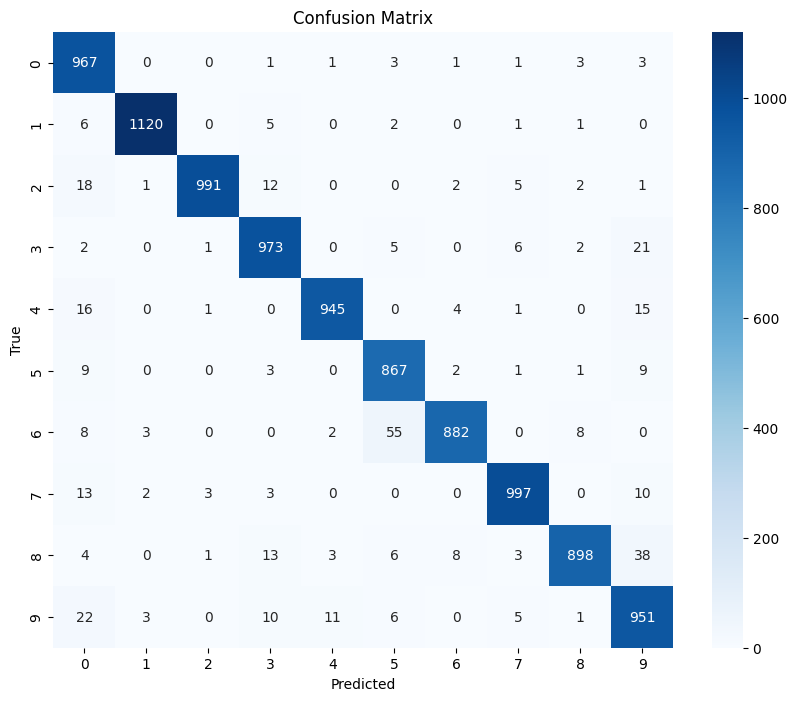

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.98      1032
           3       0.95      0.96      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.92      0.97      0.94       892
           6       0.98      0.92      0.95       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.92      0.95       974
           9       0.91      0.94      0.92      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [12]:
# Predict on the test dataset
y_pred_segments = (mlp.predict(x_test_encoded) > 0.5).astype(int)

# Convert predicted segments back to digits
segment_to_digit = {tuple(v): k for k, v in segment_mapping.items()}
y_pred_digits = np.array([segment_to_digit.get(tuple(seg), 0) for seg in y_pred_segments])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_digits)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_digits))


In [ ]:
Notes:
Expected Performance: The MLP classifier's accuracy depends on the quality of features extracted by the encoder. With sufficient training, accuracy should be high as the task involves mapping distinctive patterns.
Confusion Analysis: Use the confusion matrix to identify misclassifications and refine the architecture if needed.
